In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


In [35]:
!git add two_layer_net.ipynb

In [36]:
!git commit -m "solver"
!git push

[main b766ca9] solver
 2 files changed, 2 insertions(+), 2 deletions(-)
 rewrite assignments/assignment1/two_layer_net.ipynb (74%)
Enumerating objects: 15, done.
Counting objects: 100% (15/15), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (8/8), 550.78 KiB | 8.22 MiB/s, done.
Total 8 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/WenboKou/assignments.git
   ee09933..b766ca9  main -> main


# Affine layer: forward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [6]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [7]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [8]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [9]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1:

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
Sigmoid: The sigmoid function has an S-shaped curve and saturates at both ends (approaches 0 for negative inputs and approaches 1 for positive inputs). **When the input is either very large or very small**, the gradient of the sigmoid function becomes very close to zero because the function approaches its asymptotic values. This can lead to the vanishing gradient problem.

ReLU (Rectified Linear Unit): The ReLU function is defined as f(x) = max(0, x). It has a linear gradient of 1 for positive inputs and a gradient of 0 for negative inputs. The issue with ReLU is not the vanishing gradient but the "dying ReLU" problem, where the neuron can become inactive **for negative inputs and never activate again, leading to zero gradients**.

Leaky ReLU: This is a variation of the ReLU function that **addresses the dying ReLU problem** by allowing a small, non-zero gradient when the input is negative (f(x) = max(alpha * x, x), where alpha is a small constant). With Leaky ReLU, there is no issue of the gradient being exactly zero for negative inputs, which helps mitigate the dying ReLU problem.


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [10]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
Now implement the loss and gradient for softmax and SVM in the `softmax_loss` and `svm_loss` function in `cs231n/layers.py`. These should be similar to what you implemented in `cs231n/classifiers/softmax.py` and `cs231n/classifiers/linear_svm.py`.

You can make sure that the implementations are correct by running the following:

In [11]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  9.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.483503037636722e-09


# Two-layer network
Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [12]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.31e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves about `36%` accuracy on the validation set.

In [13]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 36% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

train_val_data = {
    "X_train": data["X_train"],
    "X_val": data["X_val"],
    "y_train": data["y_train"],
    "y_val": data["y_val"]
}
solver = Solver(model, train_val_data,
                optim_config={
                  'learning_rate': 1e-4,
                },
                lr_decay=0.95,
                print_every=100)
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.300089
(Epoch 0 / 10) train acc: 0.138000; val_acc: 0.138000
(Iteration 101 / 4900) loss: 2.240327
(Iteration 201 / 4900) loss: 2.113574
(Iteration 301 / 4900) loss: 2.026074
(Iteration 401 / 4900) loss: 2.048385
(Epoch 1 / 10) train acc: 0.297000; val_acc: 0.300000
(Iteration 501 / 4900) loss: 1.979085
(Iteration 601 / 4900) loss: 1.835247
(Iteration 701 / 4900) loss: 1.864985
(Iteration 801 / 4900) loss: 1.791849
(Iteration 901 / 4900) loss: 1.769555
(Epoch 2 / 10) train acc: 0.354000; val_acc: 0.360000
(Iteration 1001 / 4900) loss: 1.719080
(Iteration 1101 / 4900) loss: 1.742622
(Iteration 1201 / 4900) loss: 1.756344
(Iteration 1301 / 4900) loss: 1.795856
(Iteration 1401 / 4900) loss: 1.795612
(Epoch 3 / 10) train acc: 0.404000; val_acc: 0.384000
(Iteration 1501 / 4900) loss: 1.720783
(Iteration 1601 / 4900) loss: 1.765353
(Iteration 1701 / 4900) loss: 1.713281
(Iteration 1801 / 4900) loss: 1.684253
(Iteration 1901 / 4900) loss: 1.797089
(Epoch 4 / 10) t

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.36 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

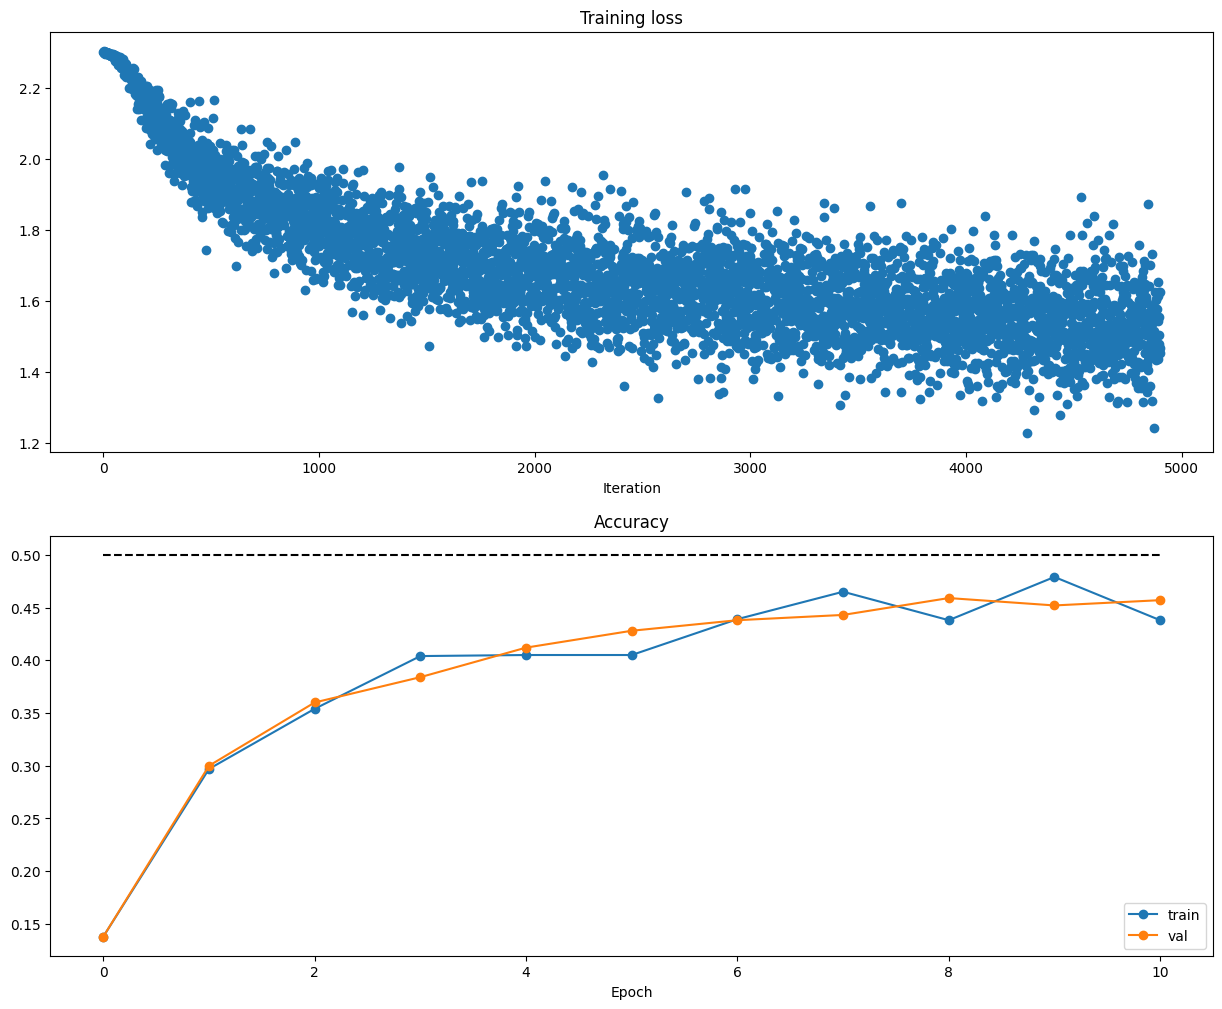

In [14]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

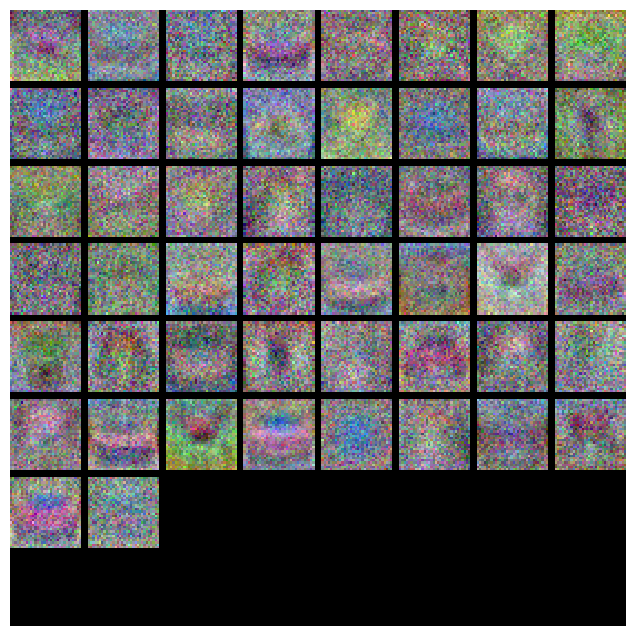

In [15]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

# hidden_size的影响，绘制hidden_size-loss的图



In [16]:
best_model = None


#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

solvers = []

input_size = 32 * 32 * 3
hidden_sizes = [384, 192, 96, 48, 24, 12, 6, 3, 1]
num_classes = 10
for hidden_size in hidden_sizes:
  model = TwoLayerNet(input_size, hidden_size, num_classes)

  solver = Solver(model, train_val_data,
                  optim_config={
                    'learning_rate': 1e-5,
                  },
                  lr_decay=0.95,
                  print_every=100,
                  num_epochs=10)
  solvers.append(solver)
  solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 4900) loss: 2.301430
(Epoch 0 / 10) train acc: 0.098000; val_acc: 0.092000
(Iteration 101 / 4900) loss: 2.281533
(Iteration 201 / 4900) loss: 2.266288
(Iteration 301 / 4900) loss: 2.246947
(Iteration 401 / 4900) loss: 2.228688
(Epoch 1 / 10) train acc: 0.224000; val_acc: 0.249000
(Iteration 501 / 4900) loss: 2.207519
(Iteration 601 / 4900) loss: 2.195624
(Iteration 701 / 4900) loss: 2.177839
(Iteration 801 / 4900) loss: 2.205437
(Iteration 901 / 4900) loss: 2.189965
(Epoch 2 / 10) train acc: 0.230000; val_acc: 0.276000
(Iteration 1001 / 4900) loss: 2.155152
(Iteration 1101 / 4900) loss: 2.118365
(Iteration 1201 / 4900) loss: 2.173505
(Iteration 1301 / 4900) loss: 2.116772
(Iteration 1401 / 4900) loss: 2.091860
(Epoch 3 / 10) train acc: 0.277000; val_acc: 0.285000
(Iteration 1501 / 4900) loss: 2.043584
(Iteration 1601 / 4900) loss: 2.091866
(Iteration 1701 / 4900) loss: 2.049758
(Iteration 1801 / 4900) loss: 1.965726
(Iteration 1901 / 4900) loss: 1.929513
(Epoch 4 / 10) t

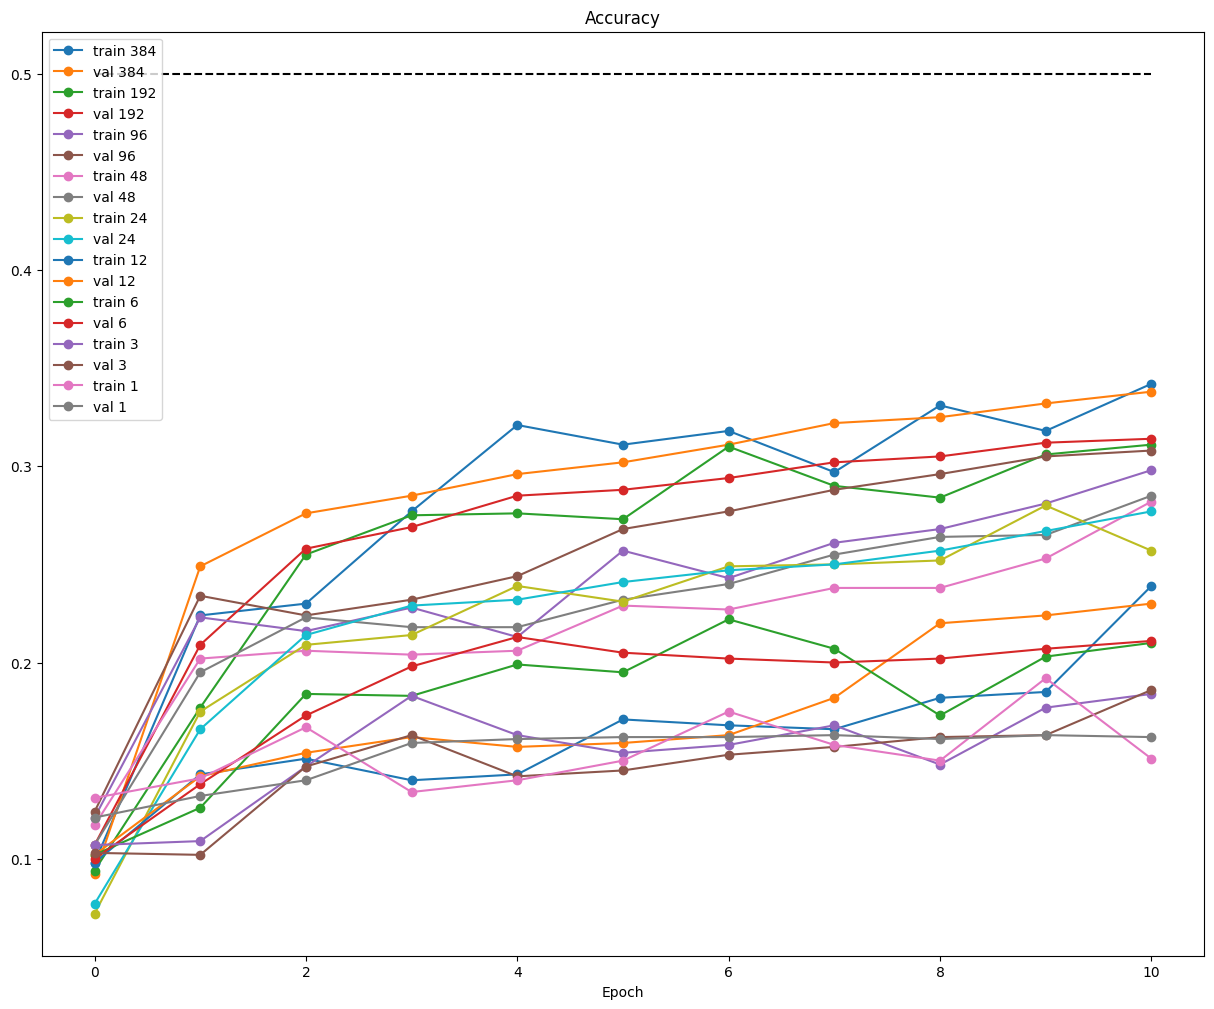

In [33]:
plt.title('Accuracy')
for solver, hidden_size in zip(solvers, hidden_sizes):
  plt.plot(solver.train_acc_history, '-o', label=f"train {hidden_size}")
  plt.plot(solver.val_acc_history, '-o', label=f"val {hidden_size}")
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.gcf().set_size_inches(15, 12)
plt.show()

With the increase of hidden size, the val/train accuracy becomes higher. But too big of the hidden size makes training speed slower.

# num_epochs的影响，绘制num_epochs-loss的图

In [39]:
input_size = 32 * 32 * 3
hidden_size = 50
num_epochs = 60
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)

solver = Solver(model, train_val_data,
                optim_config={
                  'learning_rate': 1e-5,
                },
                lr_decay=0.95,
                print_every=100,
                num_epochs=num_epochs)
solver.train()

(Iteration 1 / 29400) loss: 2.304738
(Epoch 0 / 60) train acc: 0.104000; val_acc: 0.105000
(Iteration 101 / 29400) loss: 2.301904
(Iteration 201 / 29400) loss: 2.299514
(Iteration 301 / 29400) loss: 2.294301
(Iteration 401 / 29400) loss: 2.290596
(Epoch 1 / 60) train acc: 0.165000; val_acc: 0.162000
(Iteration 501 / 29400) loss: 2.289610
(Iteration 601 / 29400) loss: 2.281854
(Iteration 701 / 29400) loss: 2.283534
(Iteration 801 / 29400) loss: 2.265418
(Iteration 901 / 29400) loss: 2.276570
(Epoch 2 / 60) train acc: 0.200000; val_acc: 0.192000
(Iteration 1001 / 29400) loss: 2.260227
(Iteration 1101 / 29400) loss: 2.249219
(Iteration 1201 / 29400) loss: 2.266653
(Iteration 1301 / 29400) loss: 2.241210
(Iteration 1401 / 29400) loss: 2.215601
(Epoch 3 / 60) train acc: 0.218000; val_acc: 0.216000
(Iteration 1501 / 29400) loss: 2.227166
(Iteration 1601 / 29400) loss: 2.190213
(Iteration 1701 / 29400) loss: 2.188575
(Iteration 1801 / 29400) loss: 2.152675
(Iteration 1901 / 29400) loss: 2.171

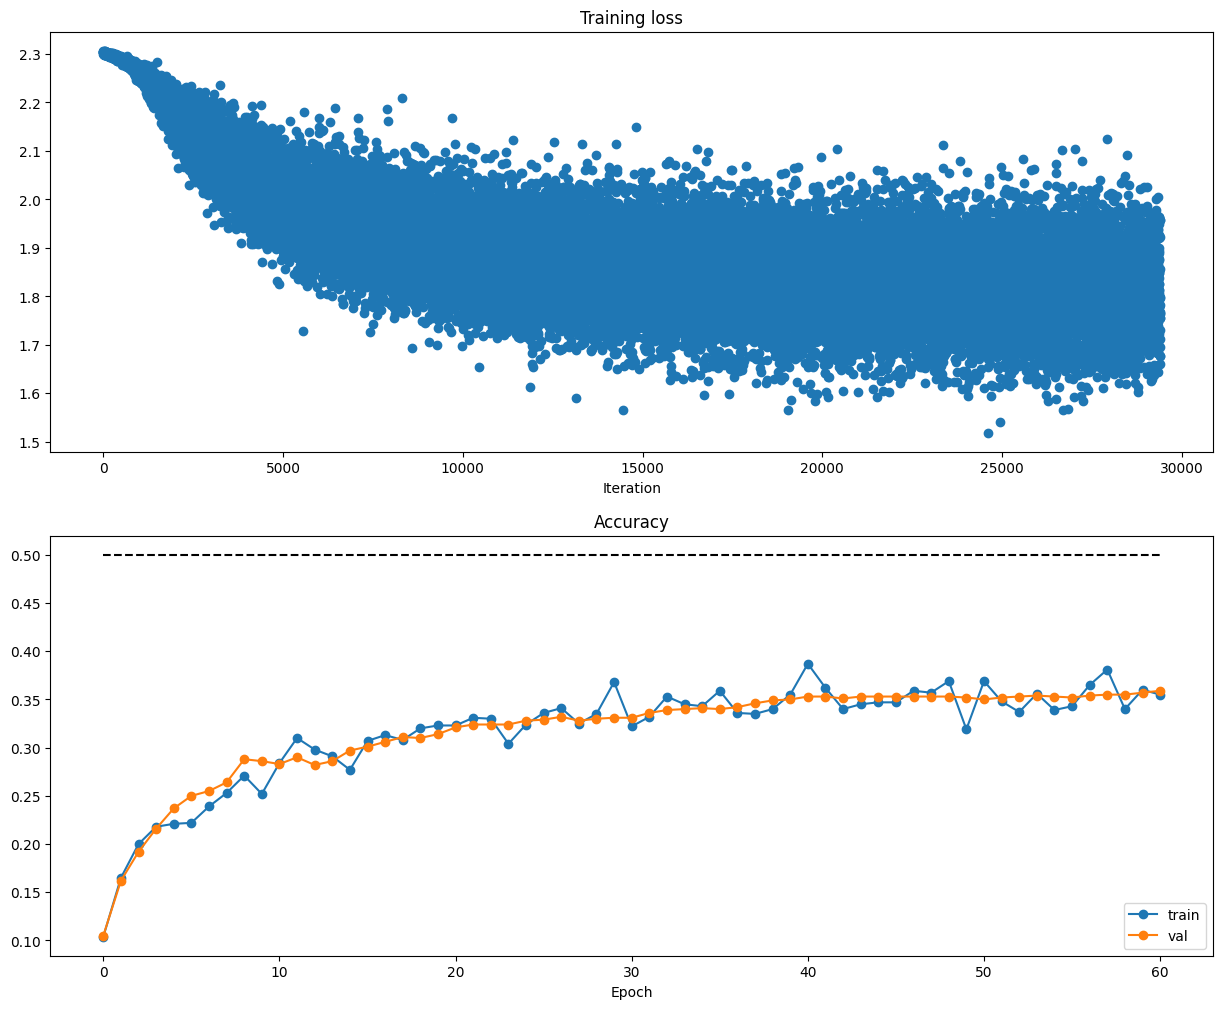

In [40]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

With the grow of epoch, the accuracy also increases and then it stagnates. Two reasons may cause this:
1. lr is becoming so small.
2. The model's inability to learn all the infomation in the data.

# lr的影响，绘制lr-loss的图

In [41]:
solvers = []
lrs = [1e-7, 1e-6, 1e-5, 1e-4, 1e-2, 1e-1, 1.0, 10.0]
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
for lr in lrs:
  model = TwoLayerNet(input_size, hidden_size, num_classes)

  solver = Solver(model, train_val_data,
                  optim_config={
                    'learning_rate': lr,
                  },
                  lr_decay=0.95,
                  print_every=100,
                  num_epochs=15)
  solvers.append(solver)
  solver.train()

(Iteration 1 / 7350) loss: 2.300674
(Epoch 0 / 15) train acc: 0.074000; val_acc: 0.094000
(Iteration 101 / 7350) loss: 2.301427
(Iteration 201 / 7350) loss: 2.306600
(Iteration 301 / 7350) loss: 2.306042
(Iteration 401 / 7350) loss: 2.302863
(Epoch 1 / 15) train acc: 0.086000; val_acc: 0.094000
(Iteration 501 / 7350) loss: 2.304629
(Iteration 601 / 7350) loss: 2.304527
(Iteration 701 / 7350) loss: 2.302055
(Iteration 801 / 7350) loss: 2.299453
(Iteration 901 / 7350) loss: 2.302416
(Epoch 2 / 15) train acc: 0.098000; val_acc: 0.097000
(Iteration 1001 / 7350) loss: 2.301147
(Iteration 1101 / 7350) loss: 2.301278
(Iteration 1201 / 7350) loss: 2.305705
(Iteration 1301 / 7350) loss: 2.303705
(Iteration 1401 / 7350) loss: 2.301966
(Epoch 3 / 15) train acc: 0.080000; val_acc: 0.097000
(Iteration 1501 / 7350) loss: 2.302786
(Iteration 1601 / 7350) loss: 2.299848
(Iteration 1701 / 7350) loss: 2.302577
(Iteration 1801 / 7350) loss: 2.303920
(Iteration 1901 / 7350) loss: 2.300040
(Epoch 4 / 15) t

/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/layers.py:817: RuntimeWarning: overflow encountered in exp
  x_exp = np.exp(x)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/layers.py:818: RuntimeWarning: invalid value encountered in divide
  probs = x_exp / x_exp.sum(axis=1, keepdims=True)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/layers.py:819: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[range(y.shape[0]), y])) / y.shape[0]


(Iteration 101 / 7350) loss: nan
(Iteration 201 / 7350) loss: nan
(Iteration 301 / 7350) loss: nan
(Iteration 401 / 7350) loss: nan
(Epoch 1 / 15) train acc: 0.088000; val_acc: 0.087000
(Iteration 501 / 7350) loss: nan
(Iteration 601 / 7350) loss: nan
(Iteration 701 / 7350) loss: nan
(Iteration 801 / 7350) loss: nan
(Iteration 901 / 7350) loss: nan
(Epoch 2 / 15) train acc: 0.113000; val_acc: 0.087000
(Iteration 1001 / 7350) loss: nan
(Iteration 1101 / 7350) loss: nan
(Iteration 1201 / 7350) loss: nan
(Iteration 1301 / 7350) loss: nan
(Iteration 1401 / 7350) loss: nan
(Epoch 3 / 15) train acc: 0.102000; val_acc: 0.087000
(Iteration 1501 / 7350) loss: nan
(Iteration 1601 / 7350) loss: nan
(Iteration 1701 / 7350) loss: nan
(Iteration 1801 / 7350) loss: nan
(Iteration 1901 / 7350) loss: nan
(Epoch 4 / 15) train acc: 0.106000; val_acc: 0.087000
(Iteration 2001 / 7350) loss: nan
(Iteration 2101 / 7350) loss: nan
(Iteration 2201 / 7350) loss: nan
(Iteration 2301 / 7350) loss: nan
(Iteration 

In [43]:
lrs.append(3e-4)
for lr in lrs:
  model = TwoLayerNet(input_size, hidden_size, num_classes)

  solver = Solver(model, train_val_data,
                  optim_config={
                    'learning_rate': lr,
                  },
                  lr_decay=0.95,
                  print_every=100,
                  num_epochs=15)
  solvers.append(solver)
  solver.train()

(Iteration 1 / 7350) loss: 2.301561
(Epoch 0 / 15) train acc: 0.134000; val_acc: 0.128000
(Iteration 101 / 7350) loss: 2.118062
(Iteration 201 / 7350) loss: 1.905991
(Iteration 301 / 7350) loss: 1.888554
(Iteration 401 / 7350) loss: 1.901491
(Epoch 1 / 15) train acc: 0.412000; val_acc: 0.392000
(Iteration 501 / 7350) loss: 1.656948
(Iteration 601 / 7350) loss: 1.732915
(Iteration 701 / 7350) loss: 1.549429
(Iteration 801 / 7350) loss: 1.575292
(Iteration 901 / 7350) loss: 1.686650
(Epoch 2 / 15) train acc: 0.446000; val_acc: 0.452000
(Iteration 1001 / 7350) loss: 1.590938
(Iteration 1101 / 7350) loss: 1.530650
(Iteration 1201 / 7350) loss: 1.662043
(Iteration 1301 / 7350) loss: 1.459937
(Iteration 1401 / 7350) loss: 1.606891
(Epoch 3 / 15) train acc: 0.480000; val_acc: 0.466000
(Iteration 1501 / 7350) loss: 1.399792
(Iteration 1601 / 7350) loss: 1.484857
(Iteration 1701 / 7350) loss: 1.439901
(Iteration 1801 / 7350) loss: 1.472862
(Iteration 1901 / 7350) loss: 1.479627
(Epoch 4 / 15) t

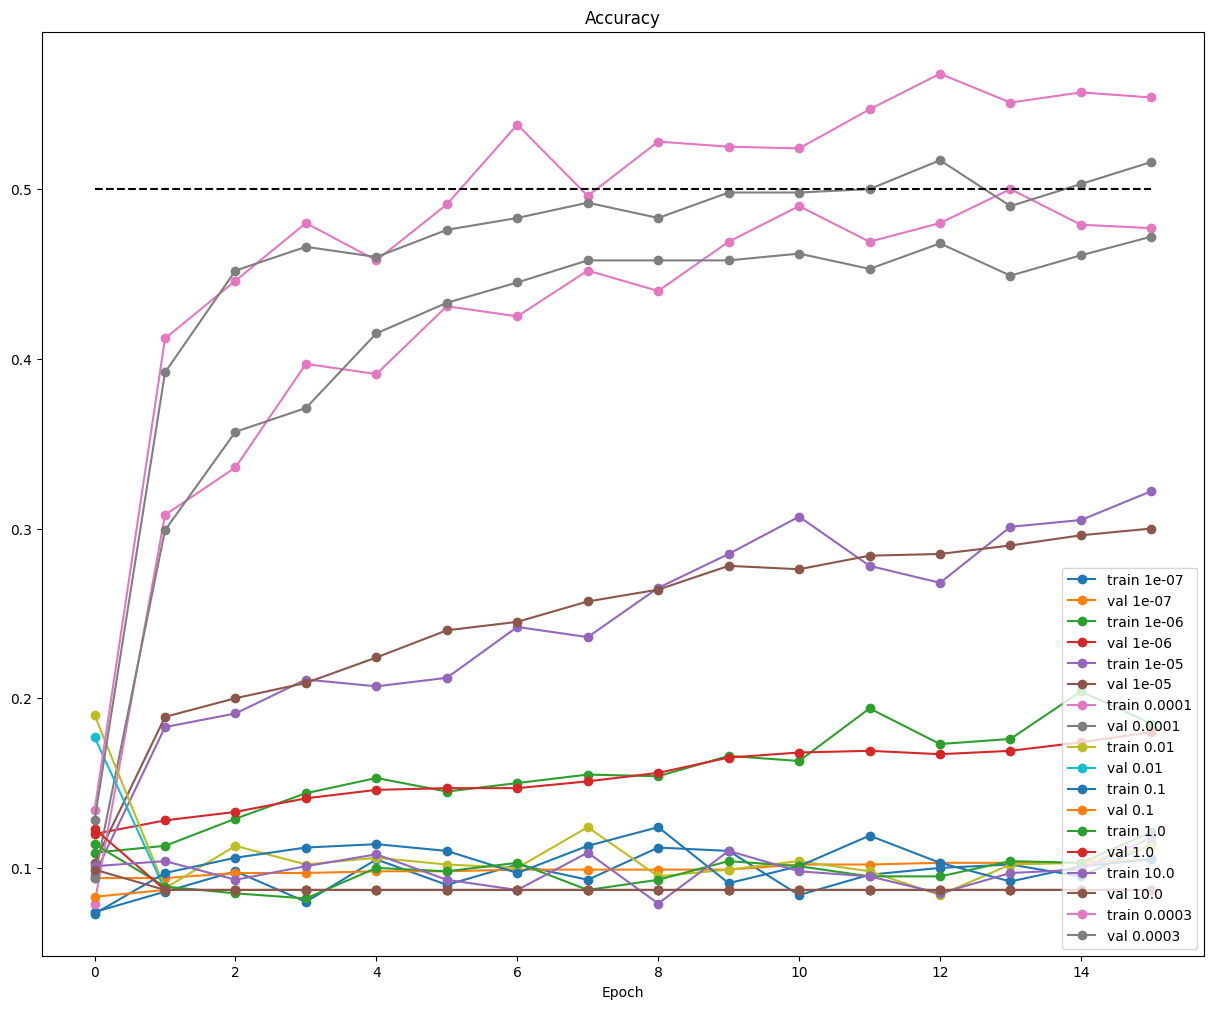

In [45]:
plt.title('Accuracy')
for solver, lr in zip(solvers, lrs):
  plt.plot(solver.train_acc_history, '-o', label=f"train {lr}")
  plt.plot(solver.val_acc_history, '-o', label=f"val {lr}")
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

lr: 3e-4 wins.
Learning rate can be crucial.

# reg的影响，绘制reg-loss的图

In [47]:
solvers = []
regs = [1000, 100, 10, 1, 1e-1, 1e-2]
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
for reg in regs:
  model = TwoLayerNet(input_size, hidden_size, num_classes, reg=reg)

  solver = Solver(model, train_val_data,
                  optim_config={
                    'learning_rate': 1e-5,
                  },
                  lr_decay=0.95,
                  print_every=100,
                  num_epochs=15)
  solvers.append(solver)
  solver.train()

(Iteration 1 / 7350) loss: 78.961259
(Epoch 0 / 15) train acc: 0.096000; val_acc: 0.092000
(Iteration 101 / 7350) loss: 12.573380
(Iteration 201 / 7350) loss: 3.678764
(Iteration 301 / 7350) loss: 2.486989
(Iteration 401 / 7350) loss: 2.327296
(Epoch 1 / 15) train acc: 0.141000; val_acc: 0.132000
(Iteration 501 / 7350) loss: 2.305931
(Iteration 601 / 7350) loss: 2.303082
(Iteration 701 / 7350) loss: 2.302658
(Iteration 801 / 7350) loss: 2.302594
(Iteration 901 / 7350) loss: 2.302588
(Epoch 2 / 15) train acc: 0.089000; val_acc: 0.078000
(Iteration 1001 / 7350) loss: 2.302585
(Iteration 1101 / 7350) loss: 2.302586
(Iteration 1201 / 7350) loss: 2.302585
(Iteration 1301 / 7350) loss: 2.302587
(Iteration 1401 / 7350) loss: 2.302586
(Epoch 3 / 15) train acc: 0.108000; val_acc: 0.078000
(Iteration 1501 / 7350) loss: 2.302581
(Iteration 1601 / 7350) loss: 2.302585
(Iteration 1701 / 7350) loss: 2.302582
(Iteration 1801 / 7350) loss: 2.302585
(Iteration 1901 / 7350) loss: 2.302588
(Epoch 4 / 15)

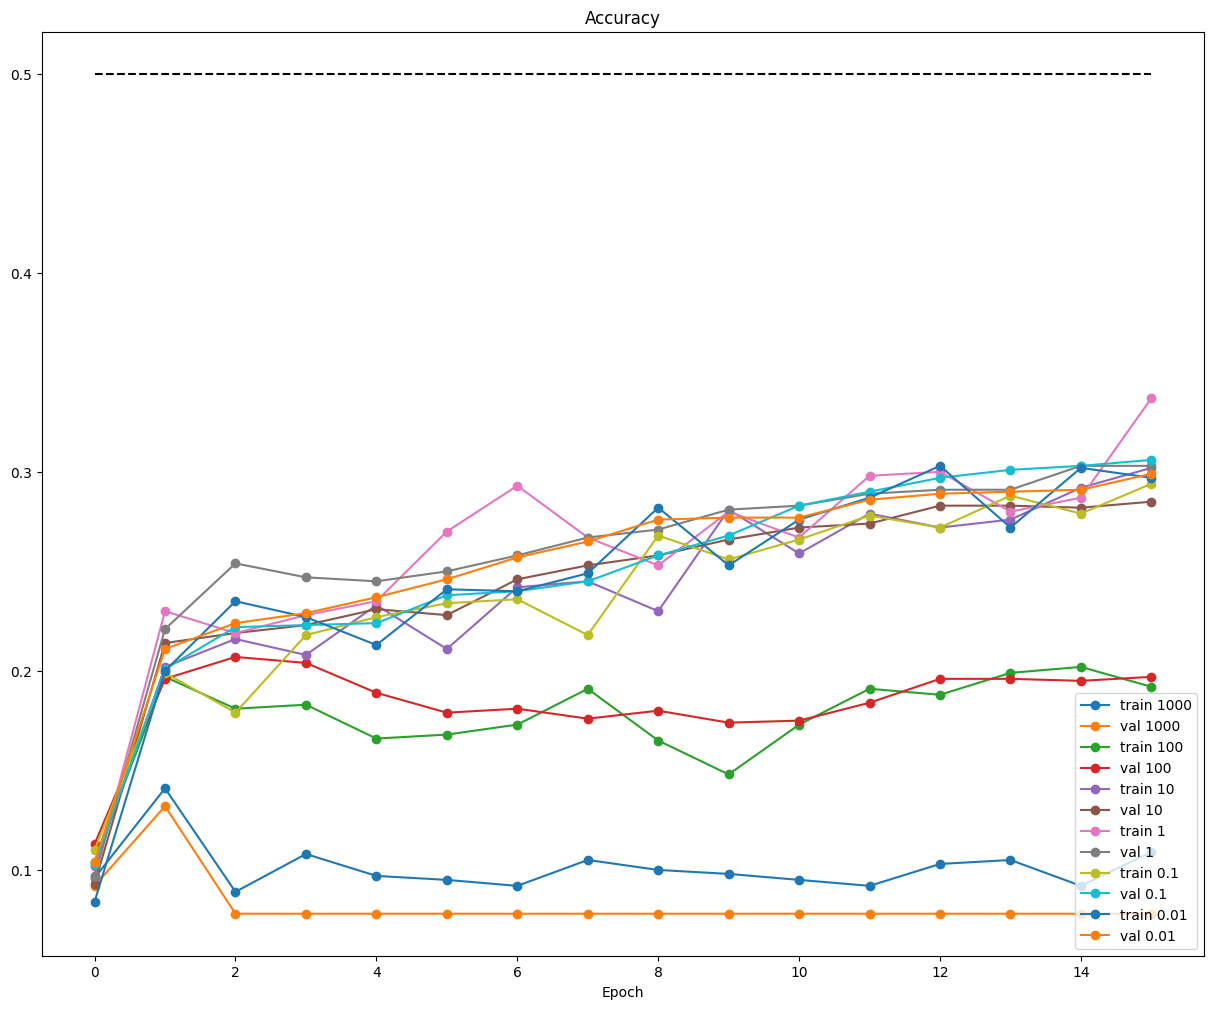

In [48]:
plt.title('Accuracy')
for solver, reg in zip(solvers, regs):
  plt.plot(solver.train_acc_history, '-o', label=f"train {reg}")
  plt.plot(solver.val_acc_history, '-o', label=f"val {reg}")
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

reg around 1 is good enough

# batch_size的影响，绘制batch_size-loss的图

In [49]:
solvers = []
batch_sizes = [49000, 24500, 12250, 6125, 1225, 600, 300, 150, 50, 20]
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
for batch_size in batch_sizes:
  model = TwoLayerNet(input_size, hidden_size, num_classes)

  solver = Solver(model, train_val_data,
                  optim_config={
                    'learning_rate': 1e-5,
                  },
                  lr_decay=0.95,
                  print_every=100,
                  num_epochs=15,
                  batch_size=batch_size)
  solvers.append(solver)
  solver.train()

(Iteration 1 / 15) loss: 2.301655
(Epoch 1 / 15) train acc: 0.105000; val_acc: 0.090000
(Epoch 2 / 15) train acc: 0.121000; val_acc: 0.090000
(Epoch 3 / 15) train acc: 0.088000; val_acc: 0.090000
(Epoch 4 / 15) train acc: 0.099000; val_acc: 0.091000
(Epoch 5 / 15) train acc: 0.093000; val_acc: 0.092000
(Epoch 6 / 15) train acc: 0.093000; val_acc: 0.092000
(Epoch 7 / 15) train acc: 0.103000; val_acc: 0.092000
(Epoch 8 / 15) train acc: 0.112000; val_acc: 0.091000
(Epoch 9 / 15) train acc: 0.091000; val_acc: 0.092000
(Epoch 10 / 15) train acc: 0.122000; val_acc: 0.092000
(Epoch 11 / 15) train acc: 0.103000; val_acc: 0.092000
(Epoch 12 / 15) train acc: 0.080000; val_acc: 0.092000
(Epoch 13 / 15) train acc: 0.120000; val_acc: 0.092000
(Epoch 14 / 15) train acc: 0.104000; val_acc: 0.091000
(Epoch 15 / 15) train acc: 0.111000; val_acc: 0.091000
(Iteration 1 / 30) loss: 2.303060
(Epoch 0 / 15) train acc: 0.078000; val_acc: 0.094000
(Epoch 1 / 15) train acc: 0.095000; val_acc: 0.093000
(Epoch 2

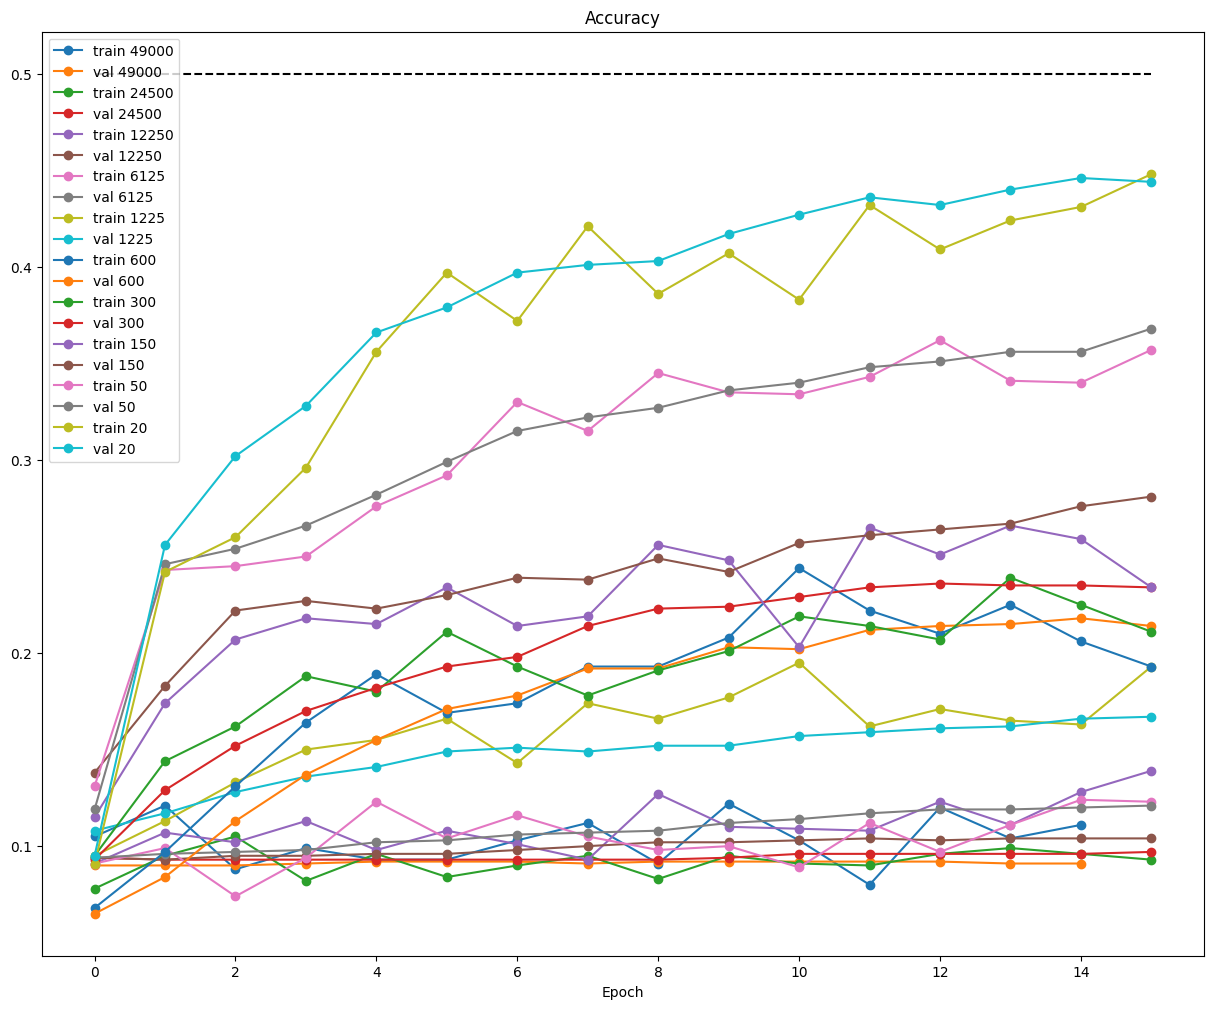

In [52]:
plt.title('Accuracy')
for solver, batch_size in zip(solvers, batch_sizes):
  plt.plot(solver.train_acc_history, '-o', label=f"train {batch_size}")
  plt.plot(solver.val_acc_history, '-o', label=f"val {batch_size}")
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [68]:
batch_sizes.extend([15, 10, 5, 1])
for batch_size in batch_sizes[-4:]:
  model = TwoLayerNet(input_size, hidden_size, num_classes)

  solver = Solver(model, train_val_data,
                  optim_config={
                    'learning_rate': 1e-5,
                  },
                  lr_decay=0.95,
                  print_every=100,
                  num_epochs=15,
                  batch_size=batch_size)
  solvers.append(solver)
  solver.train()

流式输出内容被截断，只能显示最后 5000 行内容。
(Iteration 236101 / 735000) loss: 2.516320
(Iteration 236201 / 735000) loss: 0.327135
(Iteration 236301 / 735000) loss: 0.109069
(Iteration 236401 / 735000) loss: 0.101948
(Iteration 236501 / 735000) loss: 0.594100
(Iteration 236601 / 735000) loss: 1.603123
(Iteration 236701 / 735000) loss: 1.628603
(Iteration 236801 / 735000) loss: 0.581533
(Iteration 236901 / 735000) loss: 1.055569
(Iteration 237001 / 735000) loss: 0.084959
(Iteration 237101 / 735000) loss: 0.231949
(Iteration 237201 / 735000) loss: 1.494678
(Iteration 237301 / 735000) loss: 0.219007
(Iteration 237401 / 735000) loss: 0.345981
(Iteration 237501 / 735000) loss: 1.040517
(Iteration 237601 / 735000) loss: 1.592426
(Iteration 237701 / 735000) loss: 0.906530
(Iteration 237801 / 735000) loss: 2.008354
(Iteration 237901 / 735000) loss: 2.237161
(Iteration 238001 / 735000) loss: 0.429049
(Iteration 238101 / 735000) loss: 0.499383
(Iteration 238201 / 735000) loss: 1.642890
(Iteration 238301 / 735000)

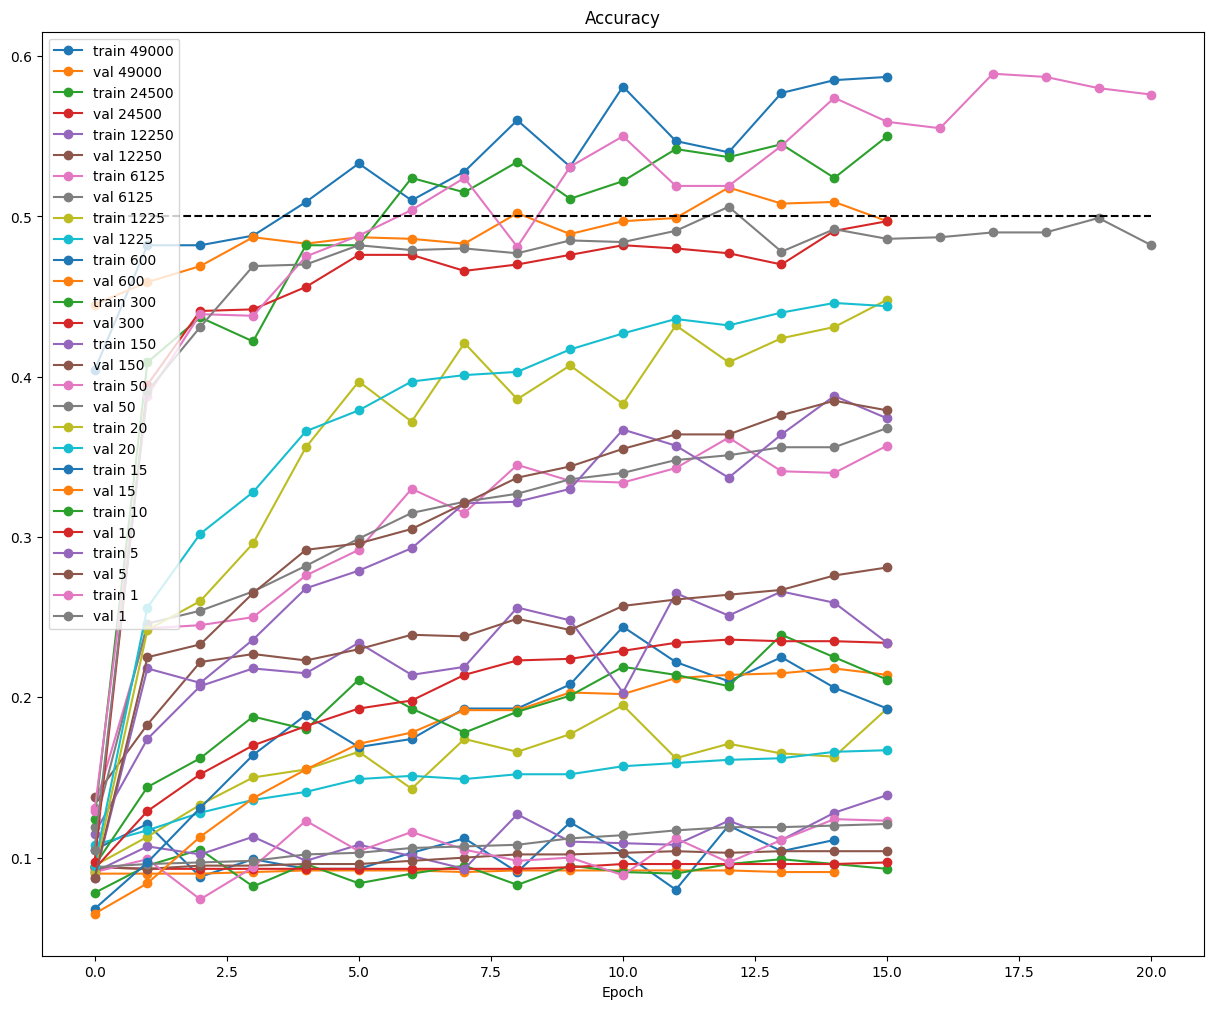

In [69]:
plt.title('Accuracy')
for solver, batch_size in zip(solvers, batch_sizes):
  plt.plot(solver.train_acc_history, '-o', label=f"train {batch_size}")
  plt.plot(solver.val_acc_history, '-o', label=f"val {batch_size}")
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.gcf().set_size_inches(15, 12)
plt.show()

1. Smaller batch size tends to perform better.
2. The batch size of 20(1/2450 of the whole dataset) performs the best.
3. The batch size of 50 performs the second best.
4. Training with large minibatches is bad for your health. More importantly, it's bad for your test error. Friends dont let friends use minibatches larger than 32. by **Yann Lecun**
5. A smaller batch size usually leads to better generalization performance because the introduced noise can act as regularization. However, a batch size that is too small may also prevent the model from converging.

# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [62]:
best_model = TwoLayerNet(input_size, hidden_size, num_classes)

solver = Solver(best_model, train_val_data,
                optim_config={
                  'learning_rate': 3e-4,
                },
                lr_decay=0.95,
                print_every=100,
                num_epochs=20)
solvers.append(solver)
solver.train()

(Iteration 1 / 9800) loss: 2.301849
(Epoch 0 / 20) train acc: 0.129000; val_acc: 0.105000
(Iteration 101 / 9800) loss: 2.014338
(Iteration 201 / 9800) loss: 1.815898
(Iteration 301 / 9800) loss: 1.906253
(Iteration 401 / 9800) loss: 1.703729
(Epoch 1 / 20) train acc: 0.388000; val_acc: 0.391000
(Iteration 501 / 9800) loss: 1.748276
(Iteration 601 / 9800) loss: 1.712239
(Iteration 701 / 9800) loss: 1.746152
(Iteration 801 / 9800) loss: 1.634932
(Iteration 901 / 9800) loss: 1.560567
(Epoch 2 / 20) train acc: 0.439000; val_acc: 0.431000
(Iteration 1001 / 9800) loss: 1.664137
(Iteration 1101 / 9800) loss: 1.539886
(Iteration 1201 / 9800) loss: 1.645379
(Iteration 1301 / 9800) loss: 1.846856
(Iteration 1401 / 9800) loss: 1.304315
(Epoch 3 / 20) train acc: 0.438000; val_acc: 0.469000
(Iteration 1501 / 9800) loss: 1.566979
(Iteration 1601 / 9800) loss: 1.664213
(Iteration 1701 / 9800) loss: 1.330012
(Iteration 1801 / 9800) loss: 1.456762
(Iteration 1901 / 9800) loss: 1.530739
(Epoch 4 / 20) t

In [64]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.506


In [65]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.5


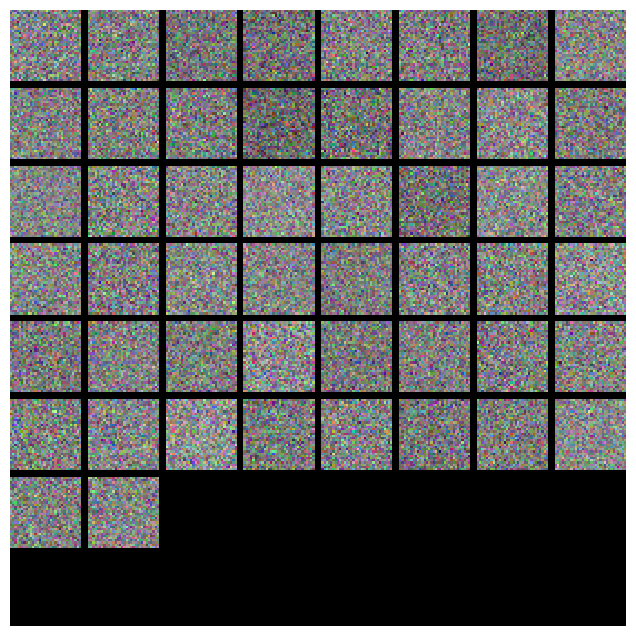

In [72]:
show_net_weights(solvers[0].model) # badly distributed weights

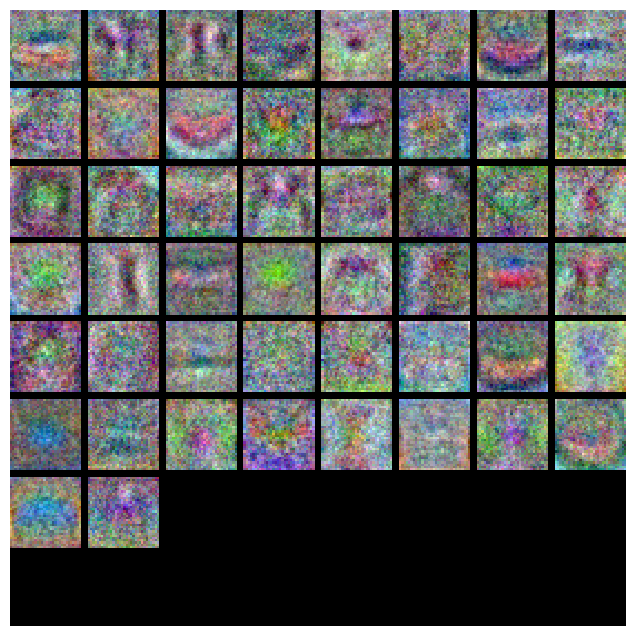

In [71]:
show_net_weights(best_model) # well distributed weights

## Inline Question 2:

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$

1 and 3 are correct

$\color{blue}{\textit Your Explanation:}$

1: More data help the model see more patterns, which can help the model to generalize to unseen data.

3: A significant gap between testing and training accuracy often indicates overfitting. Regularization helps to prevent overfitting.
